# CRISP-DM Analysis for Business Problem: Innactivity prediction with transactional data

This notebook is a companion to the Medium article (link bellow) the underlies the application with CRISP-DM methodology to understand, analyze and communicate a business problem through a proven and tested Data Science methodology.

CRISP-DM comprises of 6 steps:

Section 1: Business Understanding

Section 2: Data Understanding

Section 3: Data Preparation

Section 4: Data Modeling

Section 5: Evaluate the Results

Section 6: Deployment

Medium Article:
https://medium.com/@fernandocarliniguimaraes/innactivity-prediction-using-machine-learning-on-transacional-data-642ef7c84674

# Section 1: Business Understanding

The broader business contextualization is laid in the companion Medium Article.
A brief summary of the business undersating is laid out bellow:
A Brazilian Credit Union wishes to preempively predict Mobile phone app innactivity in a six month window. 

The business value of such endeavor lies on: 
- (1) expanding use cases of a dataset (data enrichment may lead to revenue growth); 
- (2) deterring potential customer churn (avoid revenue lost);
- (3) early detection of customer friction (garantee user satisfaction).

The business questions that arise pertaing such objective are:

### Question 1: What are aspects of a transactional dataset that can be used for understanding channel innactivity in a six month window?

### Question 2: Are mono-product-family users more likely to have channel innactivity in a six month window?

### Question 3: Can transactional data alone safely predict channel innactivity in a six month window?
    


# Section 2: Data Understanding

### Credit Union's Transaction Dataset overview

The Credit Union has several client channels. For this project we are looking at only of them: the mobile phone app. It has roughlly 4 million users, with an average of 40–45 Million transactions per month, about 40% of these are financial transacions (like paying a bill) and 60% non-financial (like looking up a bill receipt). Our main goal for the project is avoidind financial transaction innactivity, so we focused onlty on those.

All of these transactions are stored in a main database that is daily ingested in AWS Data Lake. That was the interface I used to query the data and extract it for the project.

The transacional database holds A LOT of information. But, for this project the most vital informations used were:

- Time and date the transacion happend;
- The transaction code;
- The product family the transaction is part of (example: investment application and investment cashout are two different transactions of the same product family).¹
- The Credit Union Member who solicited the transaction;
- The Credit Union the Member is linked to;
- The status of the transacion. Did it complete? Or was it canceled?
- The channel through which the transaction was solicited;

¹ There are 8 main product familys: Channels (managing your self service channel), Checking account (wire transfers), Payments (Government Tribute or company Slips), Bills (Water, Phone, etc), Credit (Loans), Cards (Credit and debit) and PIX(Brazil’s own instant payment financial product), Investments (Long Term Deposits, Market Shares);

For this project I filtered the channel to be only the Mobile App. I also chose 5 medium sized Credit Unions from our system (we have over 140) so as to have a good amount of data, but not too much as to make the processing time too long. And also fixed a six month period to analyze data.

### IMPORTANT OBSERVATION: 
This dataset is quite clean because it’s a high management information system. When we use the filters described above, like the channel filter and completed status filter, we flush out basically anything that could get in our way. The heavier data wrangling necessary is grouping the transaction codes into product families and that is still quite easy to accomplish.

### Exploratory Analysis of the Transactional Database

I have written a second article piece that show cases the method I used for both the exploratory analysis and also the model selection and development. Please check it out the article, specially the <b>Data understanding — What data do we have / need? Is it clean?</b> section for further insight.

Link:
https://medium.com/@fernandocarliniguimaraes/innactivity-prediction-using-machine-learning-on-transacional-data-642ef7c84674

### Disclaimer about Compliance and Confidentiality

Due to company compliance I had to do all of the data wrangling and manipulation on our AWS Data Lake server using Redash running a AWS Athena and AthenaSQL engine. Data was only available for extraction after anonymization. I've included in the repository a SQL file with a pseudo algorhitm that masks the sensible information (like dataset names and columns) and shows how data manipulation was done.

GitHub Repo for this project: https://github.com/nandodsg/Innactivity-Prediction-with-Transactional-Data

##### Queries using during exploratory analysis:
1. pseudo query - exploratory analysis dataset (anonymous).sql :
https://github.com/nandodsg/Innactivity-Prediction-with-Transactional-Data/blob/main/pseudo%20query%20-%20exploratory%20analysis%20dataset%20(anonymous).sql
2. pseudo query - exporatory analysis - churn flags (anonymous).sql : 
https://github.com/nandodsg/Innactivity-Prediction-with-Transactional-Data/blob/main/pseudo%20query%20-%20exporatory%20analysis%20-%20churn%20flags%20(anonymous).sql

# Section 3: Data Preparation

There can be many approches when it comes to modelling this specific business problem. One way to look at is to think of this sixth month innactivity as a kind of “churn” that we would want to predict based on a series of features (predictors). On this approch we could elect a Classifier Model for the problem.

On this solution framing we have to consider our dataset modeling base on individual and not on transactions (the would work for the Time Series model though).

We need one individual per row, with all the features laid out on separate columns. Based on the exploratory analysis I want to construct my dataframe with the following blocks:

- Account Number ID
- Credit Union Number ID
- Sixth Month Innactivity Flag (our future dependent variable)
- A depth counter (number of transacionts) by month and by product family
- An amplitude counter (number of diferente families used) by month
- Total depth counter by month

I extracted the data from the other 4 credit unions I had previously selected. This time bringing in every member who attendend one simple rule: they had to be active on the first by months of 2022. This extraction gave me a 91.848 long dataset, each row representing an unique individual.

### Disclaimer about Compliance and Confidentiality

Due to company compliance I had to do all of the data wrangling and manipulation on our AWS Data Lake server using Redash running a AWS Athena and AthenaSQL engine. Data was only available for extraction after anonymization. I've included in the repository a SQL file with a pseudo algorhitm that masks the sensible information (like dataset names and columns) and shows how data manipulation was done.

GitHub Repo for this project: https://github.com/nandodsg/Innactivity-Prediction-with-Transactional-Data

##### Query used to generate model dataset
1. pseudo query - model dataset.SQL : 
https://github.com/nandodsg/Innactivity-Prediction-with-Transactional-Data/blob/main/pseudo%20query%20-%20model%20dataset.SQL


# Section 4: Data Modeling

The following section details the development of 10 different Classifiers Models aimed at supporting the analyses of the three business questions.

I have written a second article piece that show cases the method I used for both the exploratory analysis and also the model selection and development. Please check it out the article, specially the <b>Modeling — What modeling techniques should we apply?</b> and the <b>Evaluation — Which model best meets the business objectives?</b> sections for further insight.

Link: https://medium.com/@fernandocarliniguimaraes/innactivity-prediction-using-machine-learning-on-transacional-data-642ef7c84674

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
%matplotlib inline

In [2]:
df = pd.read_csv('./Model Data Set (pseudo).csv',sep=';')
df.head()

,CREDIT_UNION_ID,ACCOUNT_NUM,FLG_202201,FLG_202202,FLG_202203,FLG_202204,FLG_202205,FLG_202206,DEEP_CHANNELS_202201,DEEP_CHANNELS_202202,...,AMP_202203,AMP_202204,AMP_202205,AMP_202206,NUM_TRANSACTIONS_202201,NUM_TRANSACTIONS_202202,NUM_TRANSACTIONS_202203,NUM_TRANSACTIONS_202204,NUM_TRANSACTIONS_202205,NUM_TRANSACTIONS_202206
0,A,ZWZZ!W,1,1,1,1,1,1,0,0,...,3,3,2,4,68,86,130,100,68,112
1,A,&WXYY&,1,1,1,1,1,1,0,0,...,1,2,2,1,14,8,4,24,12,10
2,A,Y%@YZ&,1,1,1,1,1,1,0,0,...,2,2,1,2,12,6,10,12,12,20
3,A,!W%&#!,1,1,1,1,1,1,0,0,...,3,3,2,2,38,24,36,54,72,48
4,A,%##AXY,1,1,1,1,1,1,0,0,...,3,2,3,2,24,12,12,8,6,20


In [3]:
df.shape

(91848, 68)

In [4]:
# We make sure to create a copy of the data before we start altering it. Note that we don't change the original data we loaded.
data = df.copy(deep=False)

# Preparing Variables

In [5]:
#Declare independent variables (X) and dependent variable (y)

# To avoid writing them out every time, we save the names of the estimators of our model in a list. 
independent_variables=[#PIX
            'DEEP_PIX_202201',
            'DEEP_PIX_202202',
            'DEEP_PIX_202203',
            'DEEP_PIX_202204',
            'DEEP_PIX_202205',
            #BILLS
            'DEEP_BILLS_202201',
            'DEEP_BILLS_202202',
            'DEEP_BILLS_202203',
            'DEEP_BILLS_202204',
            'DEEP_BILLS_202205',
            #CARDS
            'DEEP_CARDS_202201',
            'DEEP_CARDS_202202',
            'DEEP_CARDS_202203',
            'DEEP_CARDS_202204',
            'DEEP_CARDS_202205',
            #CHECKING
            'DEEP_CHECKING_202201',
            'DEEP_CHECKING_202202',
            'DEEP_CHECKING_202203',
            'DEEP_CHECKING_202204',
            'DEEP_CHECKING_202205',
            #CREDIT
            'DEEP_CREDIT_202201',
            'DEEP_CREDIT_202202',
            'DEEP_CREDIT_202203',
            'DEEP_CREDIT_202204',
            'DEEP_CREDIT_202205',
            #INVESTMENTS
            'DEEP_INVESTMENTS_202201',
            'DEEP_INVESTMENTS_202202',
            'DEEP_INVESTMENTS_202203',
            'DEEP_INVESTMENTS_202204',
            'DEEP_INVESTMENTS_202205',
            #PAYMENTS
            'DEEP_PAYMENTS_202201',
            'DEEP_PAYMENTS_202202',
            'DEEP_PAYMENTS_202203',
            'DEEP_PAYMENTS_202204',
            'DEEP_PAYMENTS_202205',
            #AMPLITUDE
            'AMP_202201',
            'AMP_202202',
            'AMP_202203',
            'AMP_202204',
            'AMP_202205'
           ]

X = data[independent_variables]
y = data['FLG_202206']

# Handling class imbalance

We know from our exploratory analysis that this dataset will be havily imbalanced with churn on 6th month as the minority class (represented as inactivity on that month or FLG_202206 = 0).

The problem with classifiers and class imbalance is that the classifier will more easily classify the majority class, simply because most cases are of that class. For that reason model performance metrics have to be carefully selected. Precision, recall and F1 will be used as the main metrics for evaluating performance. In our specfic case we our most interested in those metrics regarding the prediction of the minority class (0 in our case).

So in this study we will contrast the use of two wildly used classification models: Logistic Regression and RandomTreeClassifier, both with SciKit Learn implementations. Tree Ensembles our suposabily better at handling inbalance. And a common technique for getting better results is using resampling techniques. For that we will contrast model metrics on baseline models with resampled models (RandomOverSampling, SMOTE and NearMisses)


Reference:

https://medium.com/grabngoinfo/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037

https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec

https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

In [6]:
# Creating the modeling dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Model and performance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, accuracy_score, classification_report, confusion_matrix  
# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter
# Processing time
import time

In [7]:
def model_performance(model_name,resampling_name,y_test,model_prediction,verbose):
    """
    Prints the performance reports: Classification report and Confusion Matrix
    
    Inputs
    model_name = Str with model name
    resampling_name = Str with resampling method
    y_test = Test vector
    model_prediction = Prediction vector
    verbose = STR to switch execution log on or off
    
    Returns print with the reports
    """
    start_time = time.time() #Count processing time
    cr = classification_report(y_test, model_prediction)
    cm = confusion_matrix(y_test, model_prediction)
    print('\n',model_name,'with',resampling_name,' Classification Report:')
    print(cr)
    print(cm)
    
    if verbose != 'off': print("\nModel Performane processing time: --- %s seconds ---" % (time.time() - start_time))
    return cr,cm
    
    # #Precision-Recall Curve gives us the correct accuracy in this imbalanced dataset case. We can see that we have a very poor accuracy for the model.
    # precision, recall, thresholds = precision_recall_curve(model_prediction, y_test)

    # # create plot
    # plt.plot(precision, recall, label='Precision-recall curve')
    # plt.xlabel('Precision')
    # plt.ylabel('Recall')
    # plt.title('Precision-recall curve')
    # plt.legend(loc="lower left")

In [8]:
def split_resample_sets(model_name,resampling_name,X,y,test_size,random_state,verbose):
    """
    Splits and resamples X dataset and y vector.
    
    INPUT
    model_name = Str with model name
    resampling_name = Str with resampling method
    X = DataFrame with independent variables
    y = Vector with dependent (response) variable
    test_size = Float (0 to 1) for test size porcentage of the train/test split
    random_state = INT random state number
    verbose = STR to switch execution log on or off
    
    OUTPUT
    X_train = DataFrame with independent variables splitted for train set
    X_test = DataFrame with independent variables splitted for test set
    y_train = Vector with dependent variable splitted for train set
    y_test = Vector with dependent variable splitted for test set
    """
    start_time = time.time() #Count processing time
    if verbose != 'off': print('\nIniatialing split for train and test sets. \nAnalyzing need for variable rescaling.')
    if model_name == 'Logistic Regression':
        if verbose != 'off': print('\nLogistic Regression requies scaling. \nVariable rescaling necessary.')
        scaler = StandardScaler().fit(X)
        X_scaled = scaler.transform(X)
        X_scaled

        # Split into train and test
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size = test_size, random_state = random_state)
    elif model_name == 'Random Forest':
        if verbose != 'off': print('\nRandom Forest does not require rescalling.')
        # Split into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = test_size, random_state = random_state)
    
    if verbose != 'off': print('\nApplying resampling technique choosen.')
    if resampling_name == 'Baseline':
        if verbose != 'off': print("\nBaseline doesn't require resampling.")
    elif resampling_name == 'Random Over Sampling':
        if verbose != 'off': print('\nApplying',resampling_name)
        resampler = RandomOverSampler(random_state=random_state)
        X_train, y_train= resampler.fit_resample(X_train, y_train)
    elif resampling_name == 'SMOTE':
        if verbose != 'off': print('\nApplying',resampling_name)
        resampler = SMOTE(random_state=random_state)
        X_train, y_train= resampler.fit_resample(X_train, y_train)
    elif resampling_name == 'NearMiss KNN':
        if verbose != 'off': print('\nApplying',resampling_name)
        resampler = NearMiss(version=3,random_state=random_state)
        X_train, y_train= resampler.fit_resample(X_train, y_train)
    elif resampling_name == 'Random Under Sampling':
        if verbose != 'off': print('\nApplying',resampling_name)
        resampler = RandomUnderSampler(random_state=random_state)
        X_train, y_train= resampler.fit_resample(X_train, y_train)
    
    if verbose != 'off': print("\nResampling processing time: --- %s seconds ---" % (time.time() - start_time))
    return X_train, X_test, y_train, y_test

In [29]:
def define_model(model_name,random_state,verbose):
    """
    Instantiates and defines Classifier models.
    
    INPUT
    model_name = Str with model name
    random_state = INT random state number
    verbose = STR to switch execution log on or off
    
    OUTPUT
    Returns intantiated model according to users choice.
    """
    start_time = time.time() #Count processing time
    if verbose != 'off': print('\nInstantiating',model_name,'model.')
    rf = RandomForestClassifier(random_state = random_state,
                                class_weight='balanced'
                               )
    lr =  LogisticRegression(random_state = random_state,
                             class_weight='balanced',
                             penalty = 'l2'
                            )
    if model_name == 'Random Forest':
        if verbose != 'off': print('\nModel ready:',rf)
        if verbose != 'off': print("Model Instatiating processing time: --- %s seconds ---" % (time.time() - start_time))
        return rf
    elif model_name == 'Logistic Regression':
        if verbose != 'off': print('\nModel ready:',lr)
        if verbose != 'off': print("Model Instatiating processing time: --- %s seconds ---" % (time.time() - start_time))
        return lr
    else:
        print('\nNo compatible model.')

In [10]:
def model_predict(model_name,resampling_name,X,y,random_state,test_size,verbose):
    """
    Trains and Fits Models with different Resampling Techniques
    
    INPUT
    model_name = Str with model name
    resampling_name = Str with resampling technique name
    X = DataFrame with independent variables
    y = Vector with dependent (response) variable
    random_state = INT random state number
    verbose = STR to switch execution log on or off
    
    OUTPUT
    model_prediction = Vector with chosen model with resampling predictions on the test set
    """
    start_time = time.time() #Count processing time
    print('\n--------------------------------------------------------------------------------\n--------------------------------------------------------------------------------')
    if verbose != 'off': print('\nStarting new sequence:',model_name,'with',resampling_name)
    model_prediction = []
    y_train_resampled = []  
 
    
    #Define model
    model = define_model(model_name,random_state,verbose)
    #Split train and test sets + Apply scaling when need + Apply resampling
    X_train, X_test, y_train, y_test = split_resample_sets(model_name,resampling_name,X,y,test_size,random_state,verbose)
    #Train model
    if verbose != 'off': print('\nFitting model.')
    model = model.fit(X_train, y_train)
    if verbose != 'off': print("\nFitting model processing time: --- %s seconds ---" % (time.time() - start_time))
    #Predict on trained model
    if verbose != 'off': print('\nPredicting on model.')
    model_prediction = model.predict(X_test) 
    if verbose != 'off': print("\nModel prediction processing time: --- %s seconds ---" % (time.time() - start_time))
    #Evaluate model performance   
    cr,cm = model_performance(model_name,resampling_name,y_test,model_prediction,verbose)
    
    print("\nTotal processing time: --- %s seconds ---" % (time.time() - start_time))
    
    return model,cr,cm

In [20]:
def Model_Coef_Table(model_prediction):
    """
    Function for analyzing the different importance coefients of both Logistic Regression and Random Forest models.
    Prints out a table and bar graph of the top 10 coeficients (simple summ)
    
    INPUT
    model_prediction = List containing the outputs of model_predict function:
                            model = Class Fitted Classfier model instances (Logistic Regression or Ranfom Forest)
                            cr = Str Classification Report
                            cm = NP.Array Confusion Matrix
                            model_name = Str with model name
                            resampling_name = Str with resampling technique name
    OUTPUT
    Model_Coef_Table = Pandas Dataframe with Features and Coefients
                            
    """
    i=1
    Model_Coef_Table = pd.DataFrame()
    Model_Coef_Table['Features'] = X.columns
    Model_Coef_Table['Coef'] = 0
    for entry in model_prediction:
        model = entry[0] #Model
        cr = entry[1] #Classification Report
        cm = entry[2] #Confusion Matrix
        model_name = entry[3] #Model Name
        resampler_name = entry[4] #Resampler Name

    #     print('\n'+model_name+resampler_name+'\n')
        if model_name == 'Random Forest':
            importance = pd.DataFrame()
            importance['Coef'] = model.feature_importances_
            importance['Features'] = X.columns
            importance = importance.sort_values(by=['Coef'],ascending=False)

            Model_Coef_Table['Features'+model_name] = importance['Features']
            Model_Coef_Table['Coef'+model_name] = importance['Coef']
            Model_Coef_Table['Coef'] = importance['Coef'] + importance['Coef']

        elif model_name == 'Logistic Regression':
            importance = pd.DataFrame()
            importance['Coef'] = model.coef_[0]
            importance['Features'] = X.columns
            importance = importance.sort_values(by=['Coef'],ascending=False)

            Model_Coef_Table['Features'+model_name] = importance['Features']
            Model_Coef_Table['Coef'+model_name] = importance['Coef']
            Model_Coef_Table['Coef'] = importance['Coef'] + importance['Coef']

        i= i+1


    Model_Coef_Table['Coef_Avg'] = Model_Coef_Table['Coef'] / (i-1)
    Model_Coef_Table = Model_Coef_Table.sort_values(by=['Coef'],ascending=False)
    #print(Model_Coef_Table[['Features','Coef','Coef_Avg']][:5])


    fig, ax = pyplot.subplots()
    ax.barh(Model_Coef_Table['Features'][:10],Model_Coef_Table['Coef_Avg'][:10])
    
    return Model_Coef_Table, ax


## Processing and evaluating models

In [34]:
#set shared variables
random_state = 26
test_size = 0.15
#set model names
models = ['Random Forest',
          'Logistic Regression',
         ]
#set resampling names
resamplers = [
              'Baseline',
              'Random Over Sampling',
              'SMOTE',
              'Near Miss KNN',
              'Random Under Sampling',
             ]

#Instantiate empy models
model_prediction = []

for model_name in models:
    for resampler_name in resamplers:
        model,cr,cm = model_predict(model_name,resampler_name,X,y,random_state,test_size,'off')
        model_prediction.append((model,cr,cm,model_name,resampler_name))



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

 Random Forest with Baseline  Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.01      0.02       423
           1       0.97      1.00      0.98     13355

    accuracy                           0.97     13778
   macro avg       0.53      0.50      0.50     13778
weighted avg       0.94      0.97      0.95     13778

[[    5   418]
 [   54 13301]]

Total processing time: --- 9.524834871292114 seconds ---

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

 Random Forest with Random Over Sampling  Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.02      0.03       423
           1       0.97      

                Features      Coef  Coef_Avg
4        DEEP_PIX_202205  5.190888  0.519089
34  DEEP_PAYMENTS_202205  1.695646  0.169565
39            AMP_202205  1.026318  0.102632
9      DEEP_BILLS_202205  0.967727  0.096773
36            AMP_202202  0.530664  0.053066


,Features,Coef,FeaturesRandom Forest,CoefRandom Forest,FeaturesLogistic Regression,CoefLogistic Regression,Coef_Avg
4,DEEP_PIX_202205,5.190888,DEEP_PIX_202205,0.150976,DEEP_PIX_202205,2.595444,0.519089
34,DEEP_PAYMENTS_202205,1.695646,DEEP_PAYMENTS_202205,0.054880,DEEP_PAYMENTS_202205,0.847823,0.169565
39,AMP_202205,1.026318,AMP_202205,0.077617,AMP_202205,0.513159,0.102632
9,DEEP_BILLS_202205,0.967727,DEEP_BILLS_202205,0.042316,DEEP_BILLS_202205,0.483864,0.096773
36,AMP_202202,0.530664,AMP_202202,0.027963,AMP_202202,0.265332,0.053066
38,AMP_202204,0.397113,AMP_202204,0.035980,AMP_202204,0.198556,0.039711
19,DEEP_CHECKING_202205,0.331202,DEEP_CHECKING_202205,0.016287,DEEP_CHECKING_202205,0.165601,0.033120
8,DEEP_BILLS_202204,0.252594,DEEP_BILLS_202204,0.019468,DEEP_BILLS_202204,0.126297,0.025259
14,DEEP_CARDS_202205,0.241974,DEEP_CARDS_202205,0.007765,DEEP_CARDS_202205,0.120987,0.024197
37,AMP_202203,0.233947,AMP_202203,0.025754,AMP_202203,0.116973,0.023395


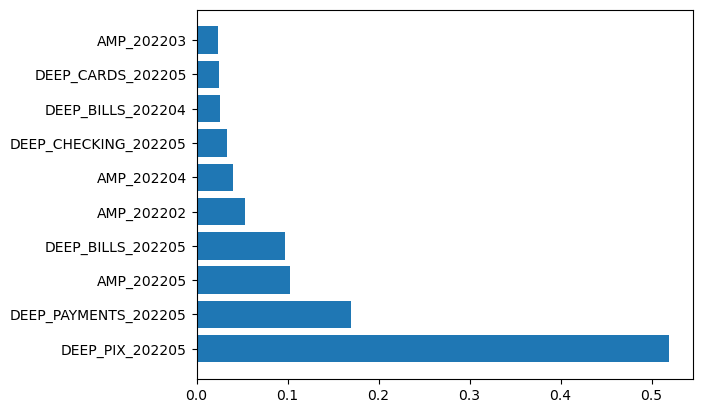

In [35]:
# Create Model Coeficient Table
Model_Coef_Table(model_prediction)


# Section 5: Evaluate the Results

This section will split up into separate analyses for each business question.

### Question 2: Are mono-product-family users more likely to have channel innactivity in a six month window?

### Question 3: Can transactional data alone safely predict channel innactivity in a six month window?

## Question 1: What are aspects of a transactional dataset that can be used for understanding channel innactivity in a six month window?

In [27]:
#Declare independent variables (X) and dependent variable (y)

# To avoid writing them out every time, we save the names of the estimators of our model in a list. 
independent_variables=[#PIX
#             'DEEP_PIX_202201',
#             'DEEP_PIX_202202',
#             'DEEP_PIX_202203',
#             'DEEP_PIX_202204',
            'DEEP_PIX_202205',
            #BILLS
#             'DEEP_BILLS_202201',
#             'DEEP_BILLS_202202',
#             'DEEP_BILLS_202203',
            'DEEP_BILLS_202204',
            'DEEP_BILLS_202205',
#             #CARDS
#             'DEEP_CARDS_202201',
#             'DEEP_CARDS_202202',
#             'DEEP_CARDS_202203',
#             'DEEP_CARDS_202204',
            'DEEP_CARDS_202205',
#             #CHECKING
#             'DEEP_CHECKING_202201',
#             'DEEP_CHECKING_202202',
#             'DEEP_CHECKING_202203',
#             'DEEP_CHECKING_202204',
            'DEEP_CHECKING_202205',
#             #CREDIT
#             'DEEP_CREDIT_202201',
#             'DEEP_CREDIT_202202',
#             'DEEP_CREDIT_202203',
#             'DEEP_CREDIT_202204',
#             'DEEP_CREDIT_202205',
#             #INVESTMENTS
#             'DEEP_INVESTMENTS_202201',
#             'DEEP_INVESTMENTS_202202',
#             'DEEP_INVESTMENTS_202203',
#             'DEEP_INVESTMENTS_202204',
#             'DEEP_INVESTMENTS_202205',
#             #PAYMENTS
#             'DEEP_PAYMENTS_202201',
#             'DEEP_PAYMENTS_202202',
#             'DEEP_PAYMENTS_202203',
#             'DEEP_PAYMENTS_202204',
            'DEEP_PAYMENTS_202205',
#             #AMPLITUDE
#             'AMP_202201',
            'AMP_202202',
            'AMP_202203',
            'AMP_202204',
            'AMP_202205'
           ]

X1 = data[independent_variables]
y1 = data['FLG_202206']

In [30]:
#set shared variables
random_state = 26
test_size = 0.15
#set model names
models = ['Random Forest',
          'Logistic Regression',
         ]
#set resampling names
resamplers = [
              'Baseline',
              'Random Over Sampling',
              'SMOTE',
              'Near Miss KNN',
              'Random Under Sampling',
             ]

#Instantiate empy models
model_prediction_revisited = []

for model_name in models:
    for resampler_name in resamplers:
        model,cr,cm = model_predict(model_name,resampler_name,X1,y1,random_state,test_size,'off')
        model_prediction.append((model,cr,cm,model_name,resampler_name))
        



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

 Random Forest with Baseline  Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.38      0.17       423
           1       0.98      0.90      0.94     13355

    accuracy                           0.88     13778
   macro avg       0.54      0.64      0.55     13778
weighted avg       0.95      0.88      0.91     13778

[[  162   261]
 [ 1337 12018]]

Total processing time: --- 4.5156090259552 seconds ---

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

 Random Forest with Random Over Sampling  Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.41      0.16       423
           1       0.98      0.

              Features  Coef  Coef_Avg
0      DEEP_PIX_202201     0       NaN
1      DEEP_PIX_202202     0       NaN
22  DEEP_CREDIT_202203     0       NaN
23  DEEP_CREDIT_202204     0       NaN
24  DEEP_CREDIT_202205     0       NaN


,Features,Coef,Coef_Avg
0,DEEP_PIX_202201,0,NaN
1,DEEP_PIX_202202,0,NaN
22,DEEP_CREDIT_202203,0,NaN
23,DEEP_CREDIT_202204,0,NaN
24,DEEP_CREDIT_202205,0,NaN
25,DEEP_INVESTMENTS_202201,0,NaN
26,DEEP_INVESTMENTS_202202,0,NaN
27,DEEP_INVESTMENTS_202203,0,NaN
28,DEEP_INVESTMENTS_202204,0,NaN
29,DEEP_INVESTMENTS_202205,0,NaN


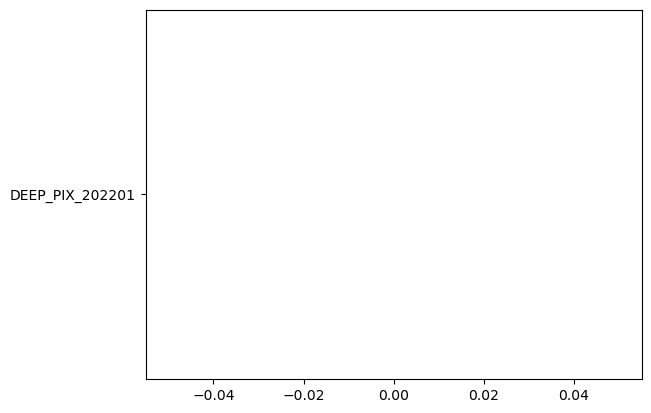

In [33]:
# Create Model Coeficient Table
Model_Coef_Table(model_prediction_revisited)

# Evaluation

Though the exploratory analysis indicated the possibily of finding correlation between transaction patterns and innactivity, the two classifiers and 4 resampling techniques used did not present good performance on this highly imbalanced dataset. 

The models just didn't perform well! Unfortunatelly. But hey, this is a scientific approach, know that something doesn't work is also a valid result, it just brushes off the false positives from your line of sight.

All models had precision scores ranging from 0.08 to 0.09, recall from 0.83 to 0.85 and f1-score at exactlly 0.15. The main difference seeable at the confusion matrix, with slight differences on the true/false positive/negative predictions. The RandomForest with Random Under Sampling had similiar measures: precision at 0.09, recall at 0.77 and f1-score at 0.16.
Exemple of Classification Report and Confusion Matrix for the Logistic Regression with Baseline model.

The models actually did an interesting job of predicting 325+ cases of the 423 innactivity targets in the test set (you can see that looking at the confusion matrix's top left quadrant, 358 in the example above). That is why the Recall (or sensitivity) is high. 

This means the model is more confident at trying to predict the minority cases (the Random Forest Baseline practically didn't even try to predict the minority cases, in the report in only classified 15 as negatives, and 14 of them were flase - check the print screen bellow).

# Conclusion

Unfortunately this project doesn't seem to provide strong evidence towards answering either positively or negatively the business question provided.

Our exploratory analysis show their is a potential correlation to be explored between innactivaty, depth (specially PIX) and amplitude. But, the use of classifier models, at least with the present configuration, haven't presented promising results.

### Recommendations on future studies

1. Study the use of time series prediction techniques as a subsititue for Classifiers
2. Use the accumlative transactional variation on 5 months prior to the 6th month innactivity prediction may wielf better results than using the absolute number of transations per month as features.